In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns        
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# A - Data

In [66]:
data = pd.read_csv('Bengaluru_House_Data.csv')

In [67]:
data.shape

(13320, 9)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


# B - Loại bỏ đặc trưng


<function matplotlib.pyplot.show(close=None, block=None)>

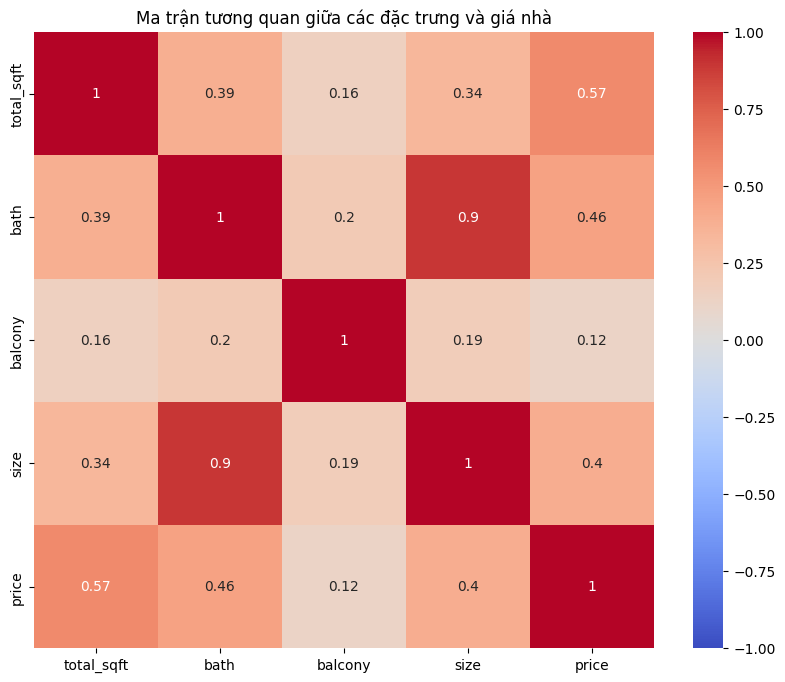

In [69]:
# Chuẩn hóa tạm thời các cột số để tính tương quan
temp_data = data.copy()
temp_data['size'] = temp_data['size'].apply(lambda x: int(x.split()[0]) if isinstance(x, str) else np.nan)
temp_data['total_sqft'] = temp_data['total_sqft'].apply(lambda x: float(x) if isinstance(x, str) and x.replace('.', '').isdigit() else np.nan)
corr_columns = ['total_sqft', 'bath', 'balcony', 'size', 'price']
corr_data = temp_data[corr_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Ma trận tương quan giữa các đặc trưng và giá nhà')
plt.show

In [70]:
columns_to_drop = ['area_type', 'society', 'balcony', 'availability']

In [71]:
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

# C - Xử lý giá trị thiếu

In [72]:
data.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [73]:
def parse_size(size):
    try:
        return int(size.split()[0])  # Lấy số đầu tiên từ chuỗi (ví dụ: "2 BHK" -> 2)
    except:
        return np.nan  # Trả về NaN nếu lỗi

def parse_sqft(sqft):
    try:
        return float(sqft)  # Chuyển chuỗi thành số thực (ví dụ: "1056" -> 1056.0)
    except:
        return np.nan  # Trả về NaN nếu lỗi

In [74]:
# Xử lý cột 'size' và điền giá trị thiếu bằng trung vị
data['size'] = data['size'].apply(parse_size)
data['size'] = data['size'].fillna(data['size'].median())

# Xử lý cột 'total_sqft' và điền giá trị thiếu bằng trung vị
data['total_sqft'] = data['total_sqft'].apply(parse_sqft)
data['total_sqft'] = data['total_sqft'].fillna(data['total_sqft'].median())

# Điền giá trị thiếu ở cột 'bath' bằng trung vị
data['bath'] = data['bath'].fillna(data['bath'].median())

# Loại bỏ các hàng thiếu 'location' hoặc 'price'
data = data.dropna(subset=['location', 'price'])
print("Đã xử lý giá trị thiếu và chuẩn hóa cột size, total_sqft. Kích thước mới:", data.shape)

Đã xử lý giá trị thiếu và chuẩn hóa cột size, total_sqft. Kích thước mới: (13319, 5)


# D - Kỹ thuật đặc trưng


In [75]:
# Tạo đặc trưng mới 'price_per_sqft' để chuẩn hóa giá nhà
data['price_per_sqft'] = data['price'] / data['total_sqft']
print("Đã tạo đặc trưng mới: price_per_sqft")

Đã tạo đặc trưng mới: price_per_sqft


In [76]:
data.head()

,location,size,total_sqft,bath,price,price_per_sqft
0,Electronic City Phase II,2.0,1056.0,2.0,39.07,0.036998
1,Chikka Tirupathi,4.0,2600.0,5.0,120.00,0.046154
2,Uttarahalli,3.0,1440.0,2.0,62.00,0.043056
3,Lingadheeranahalli,3.0,1521.0,3.0,95.00,0.062459
4,Kothanur,2.0,1200.0,2.0,51.00,0.042500


In [77]:
data = data[~(data.total_sqft/data.bath < 300)]

In [78]:
# Loại bỏ ngoại lệ bằng phương pháp trung bình và độ lệch chuẩn
def remove_outliers(df, column):
    mean = df[column].mean()  # Tính trung bình
    std = df[column].std()    # Tính độ lệch chuẩn
    lower_bound = mean - 3 * std  # Giới hạn dưới
    upper_bound = mean + 3 * std  # Giới hạn trên
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Áp dụng loại bỏ ngoại lệ cho 'price', 'total_sqft', và 'price_per_sqft'
data = remove_outliers(data, 'price')
data = remove_outliers(data, 'total_sqft')
data = remove_outliers(data, 'price_per_sqft')
print("Đã loại bỏ ngoại lệ. Kích thước mới:", data.shape)


Đã loại bỏ ngoại lệ. Kích thước mới: (12102, 6)


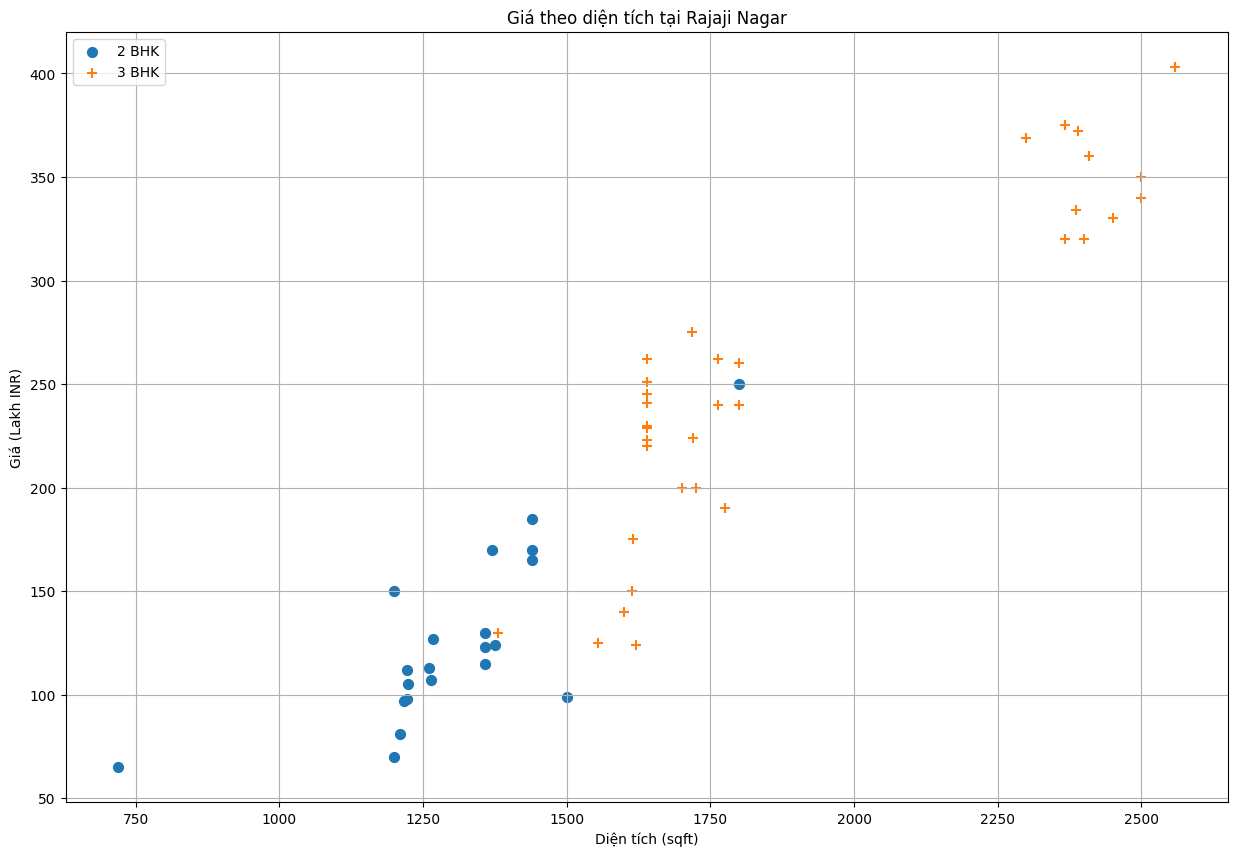

In [79]:
import matplotlib.pyplot as plt

def plot_scatter_chart(df, location):
    # Tạo mask chung cho location
    loc_mask = (df.location == location)
    
    # Mask cho 2 BHK và 3 BHK
    mask2 = loc_mask & (df.bath == 2)
    mask3 = loc_mask & (df.bath == 3)
    
    # Khởi tạo kích thước biểu đồ
    plt.figure(figsize=(15, 10))
    
    # Vẽ scatter mà không cần tạo DataFrame phụ
    plt.scatter(df.total_sqft[mask2], df.price[mask2],
                label='2 BHK', s=50)
    plt.scatter(df.total_sqft[mask3], df.price[mask3],
                marker='+', label='3 BHK', s=50)
    
    # Thêm nhãn và tiêu đề
    plt.xlabel("Diện tích (sqft)")
    plt.ylabel("Giá (Lakh INR)")
    plt.title(f"Giá theo diện tích tại {location}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Gọi hàm
plot_scatter_chart(data, "Rajaji Nagar")


In [85]:
def extract_bhk(x):
    try:
        return int(float(str(x).split()[0]))
    except:
        return np.nan

# Áp dụng và fill missing
data['bhk'] = data['size'].apply(extract_bhk)
data['bhk'].fillna(data['bhk'].median(), inplace=True)
data['bhk'] = data['bhk'].astype(int)
# Xóa cột size sau khi đã trích số bhk
data.drop('size', axis=1, inplace=True)

In [87]:
# 7. Mã hóa one-hot cho cột danh mục
cat_cols = ['location', 'bhk']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# 8. Chuẩn bị dữ liệu huấn luyện và kiểm tra
X = data.drop(['price', 'price_per_sqft'], axis=1)
y = data['price']  # price là giá tính theo lakh
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
# 9. Khởi tạo và huấn luyện mô hình
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}
# Siêu tham số cho GridSearchCV
param_grid = {
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1]},
    'DecisionTree': {'max_depth': [None, 5, 10, 20]}
}

best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='r2')
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        print(f"Best {name}: {grid.best_params_}")
        best_models[name] = best
    else:
        model.fit(X_train, y_train)
        best_models[name] = model


Best Lasso: {'alpha': 0.01}
Best DecisionTree: {'max_depth': 5}


In [89]:
def evaluate_model(model, X_t, y_t):
    preds = model.predict(X_t)
    mae = mean_absolute_error(y_t, preds)
    mse = mean_squared_error(y_t, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_t, preds)
    print(f"Model: {model.__class__.__name__}")
    print(f" MAE: {mae:.4f}")
    print(f" MSE: {mse:.4f}")
    print(f" RMSE: {rmse:.4f}")
    print(f" R2 Score: {r2:.4f}\n")

for m in best_models.values():
    evaluate_model(m, X_test, y_test)


Model: LinearRegression
 MAE: 89645468.4320
 MSE: 1235431051284727552.0000
 RMSE: 1111499460.7667
 R2 Score: -245126063689065.7188

Model: Lasso
 MAE: 21.5624
 MSE: 1241.8300
 RMSE: 35.2396
 R2 Score: 0.7536

Model: DecisionTreeRegressor
 MAE: 22.9533
 MSE: 1368.7809
 RMSE: 36.9970
 R2 Score: 0.7284

